In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 648M/658M [00:09<00:00, 96.6MB/s]
100% 658M/658M [00:09<00:00, 69.8MB/s]


In [4]:
import zipfile

zip_ref = zipfile.ZipFile('/content/plantdisease.zip' , 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import img_to_array , load_img
from keras import models
from keras.models import Sequential
from keras.layers import Dense , Conv2D , Dropout


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [8]:

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Potato Leaves',
    shuffle = True,
    image_size = (IMG_SIZE , IMG_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [9]:
classes = dataset.class_names

In [10]:
for image_batch , label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 0 1 1 0 0 0 1 1 2 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 2 2 1 0 2]


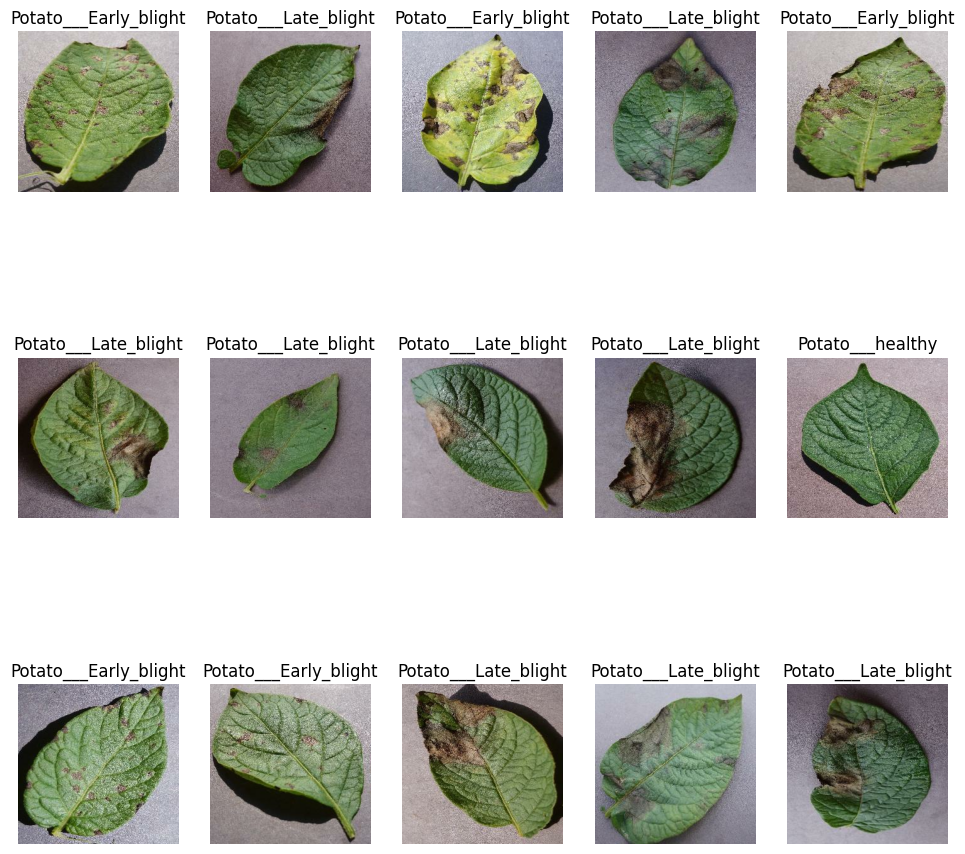

In [11]:
plt.figure(figsize=(12,12))
for image_batch , label_batch in dataset.take(1):
  for i in range(15):
    ax = plt.subplot(3,5 ,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(classes[label_batch[i]])
    plt.axis('off')

In [12]:
len(dataset)

68

In [13]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [14]:
train_data , val_data , test_data = get_dataset_partitions(dataset)

In [15]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = Sequential([
    tf.keras.layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1./255),
])

In [17]:
augmenting = Sequential([
    layers.RandomFlip('vertical and horizontal'),
    layers.RandomRotation(0.35),

])

In [18]:
train_data = train_data.map(lambda x ,y: (augmenting(x , training = True),y)).prefetch(buffer_size = tf.data.AUTOTUNE)


In [19]:
# input_shape = (BATCH_SIZE,IMG_SIZE, IMG_SIZE ,CHANNELS)
# n_classes = 3

# model = Sequential([
#     keras.Input(shape = (32,256,256,3)),
#     resize_and_rescale,
#     layers.Conv2D(32 ,(3,3), activation = 'relu'),
#     layers.MaxPool2D((2,2)),
#     layers.Conv2D(64 ,(3,3), activation = 'relu'),
#     layers.MaxPool2D((2,2)),
#     layers.Conv2D(64 ,(3,3), activation = 'relu'),
#     layers.MaxPool2D((2,2)),
#     layers.Conv2D(128 ,(3,3), activation = 'relu'),
#     layers.MaxPool2D((2,2)),
#     layers.Flatten(),
#     layers.Dense(128 , activation = 'relu'),
#     layers.Dense(n_classes, activation = 'softmax')
# ])


In [20]:
n_classes = 3

model = Sequential([
    keras.Input(shape = (256, 256, 3)), #no need to specify batch size here
    resize_and_rescale,             # Apply resizing and rescaling
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

# model.build(input_shape= (256,256,3))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 757,443 (2.89 MB)

 Trainable params: 757,443 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(optimizer= 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

In [22]:
history = model.fit(train_data , batch_size = 32 , epochs= 50 , validation_data = val_data ,verbose = 1 )

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 330ms/step - accuracy: 0.4850 - loss: 0.9266 - val_accuracy: 0.4792 - val_loss: 0.8156
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 214ms/step - accuracy: 0.6472 - loss: 0.7729 - val_accuracy: 0.8021 - val_loss: 0.5858
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step - accuracy: 0.8211 - loss: 0.5229 - val_accuracy: 0.8750 - val_loss: 0.3389
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 227ms/step - accuracy: 0.8658 - loss: 0.3088 - val_accuracy: 0.9271 - val_loss: 0.3100
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 227ms/step - accuracy: 0.9081 - loss: 0.2550 - val_accuracy: 0.9531 - val_loss: 0.1359
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step - accuracy: 0.9405 - loss: 0.1606 - val_accuracy: 0.9427 - val_loss: 0.1561
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - accuracy: 0.9430 - loss: 0.1628 - val_accuracy: 0.9740 - val_loss: 0.0806
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 214ms/step - accuracy: 0.9301 - loss: 0.1731 - val_accu

In [24]:
scores = model.evaluate(test_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9783 - loss: 0.0750


In [25]:
scores

[0.05689635127782822, 0.984375]

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

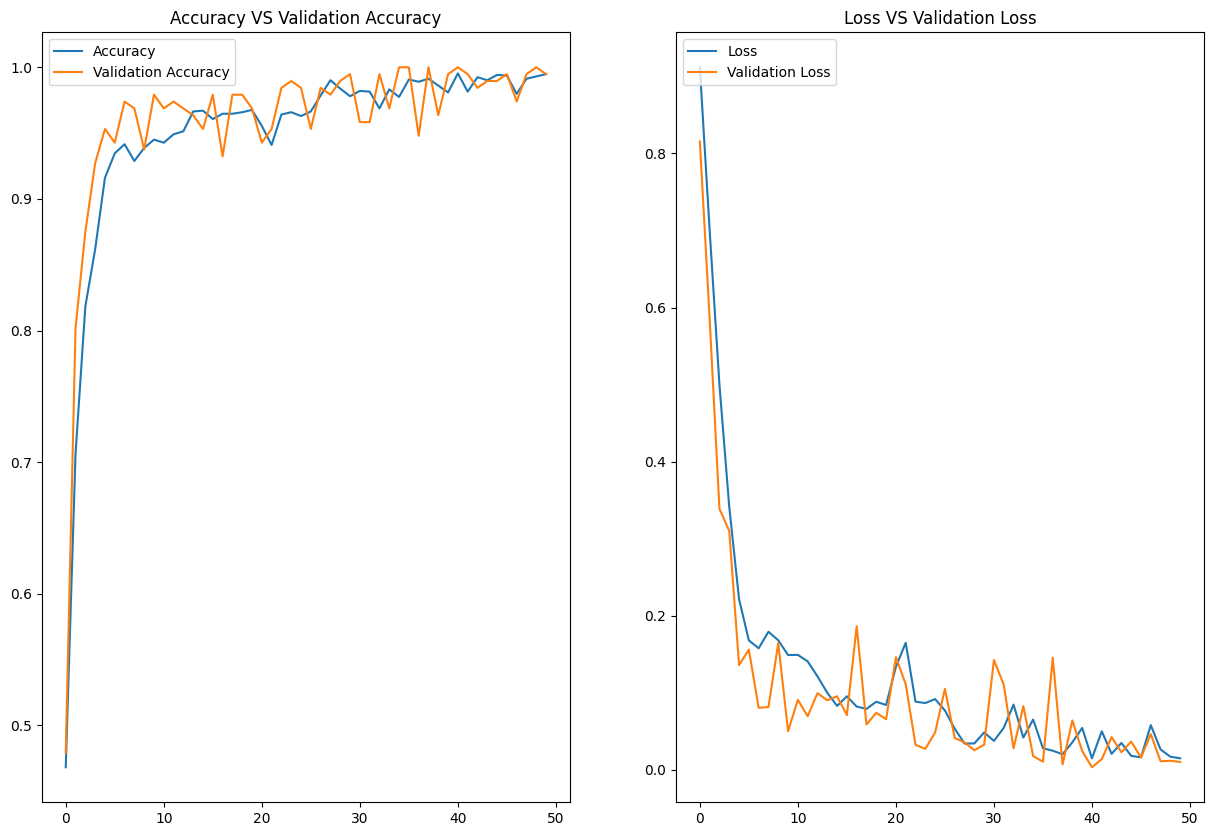

In [30]:
plt.figure(figsize= (15,10))

plt.subplot(1,2,1)
plt.plot(range(50), acc , label = 'Accuracy')
plt.plot(range(50), val_acc , label = 'Validation Accuracy')
plt.legend(loc = 'upper left')
plt.title('Accuracy VS Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(50), loss , label = 'Loss')
plt.plot(range(50), val_loss , label = 'Validation Loss')
plt.legend(loc = 'upper left')
plt.title('Loss VS Validation Loss')

plt.show()

First image to predict  AxesImage(shape=(256, 256, 3))
Actual Label of Image :  Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Label :  Potato___healthy


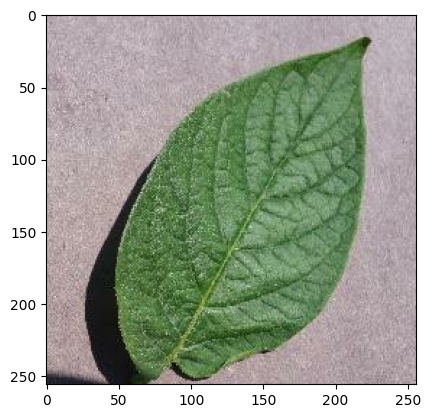

In [48]:
import numpy as np

for image_batch , label_batch in test_data.take(1):

  image1 = image_batch[0].numpy().astype('uint8')
  label1 = label_batch[0].numpy()

  print('First image to predict ' , plt.imshow(image1))
  print("Actual Label of Image : " , classes[label1])

  Prediction  = model.predict(image_batch)
  print("Predicted Label : " , classes[np.argmax(Prediction[0])])


In [55]:
def model_prediction(model , image):

      img = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
      img = tf.expand_dims(img,0)

      predictions = model.predict(img)
      predicted_class = classes[np.argmax(predictions[0])]
      confidence = round(100* (np.max(predictions[0])), 2)

      return predicted_class , confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


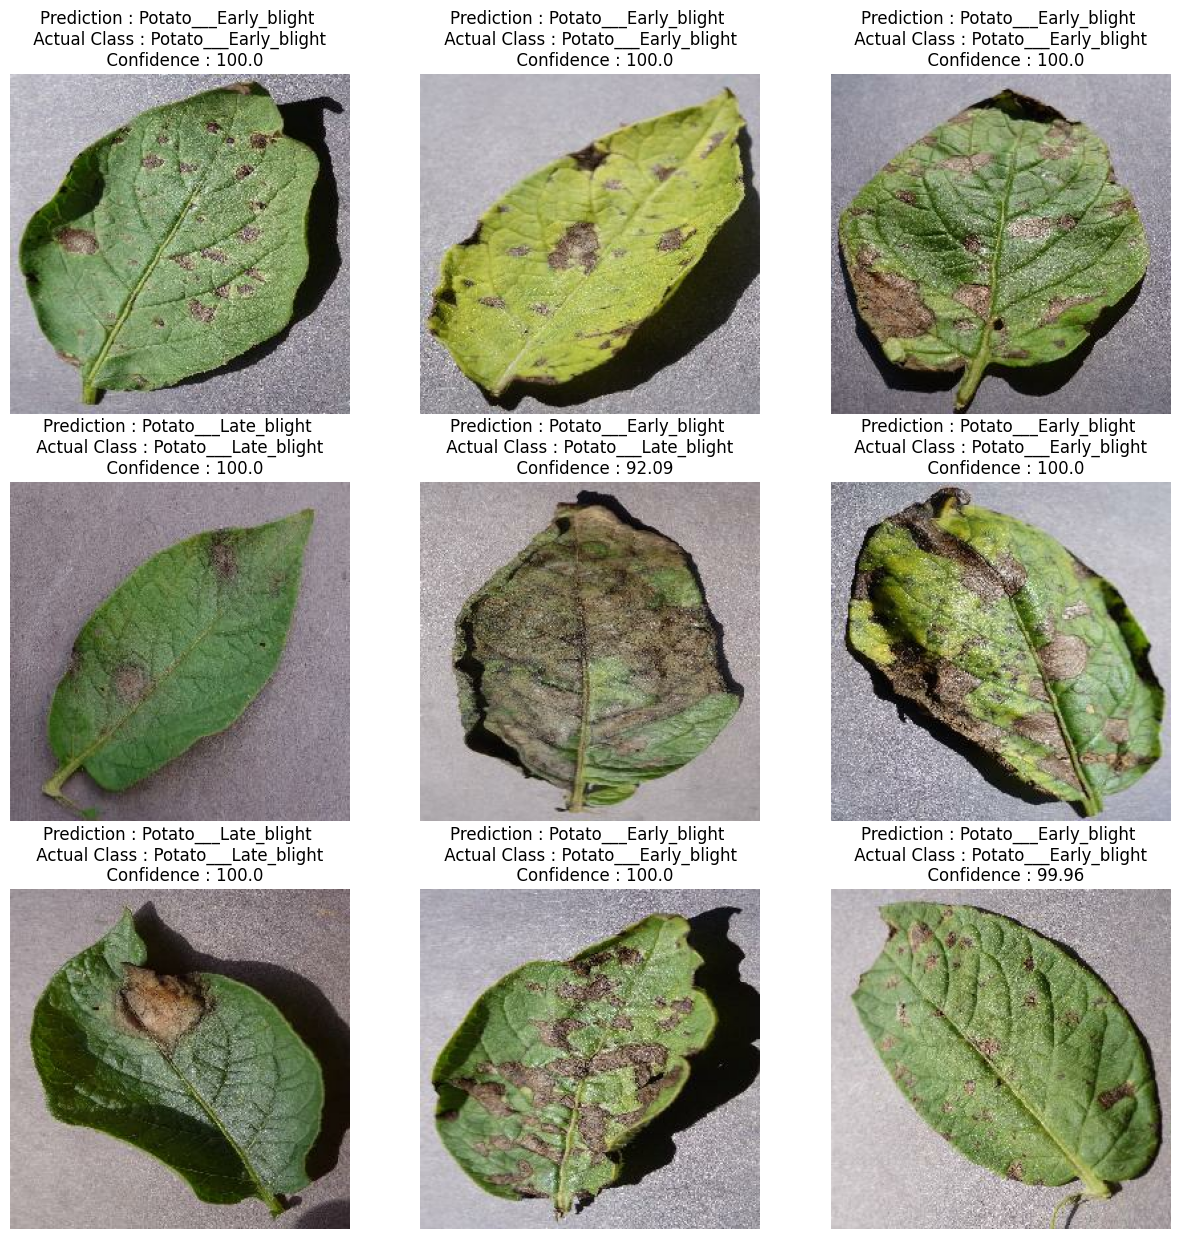

In [61]:
plt.figure(figsize = (15,15))

for images , labels in test_data.take(2):
  for i in range(9):

    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class , confidence = model_prediction(model , images[i].numpy())
    real_class = classes[labels[i]]

    plt.title(f"Prediction : {predicted_class} \n Actual Class : {real_class} \n  Confidence : {confidence}")
    plt.axis("off")
    # plt.show()



In [65]:
from typing import final
import os
import pickle
import joblib
from joblib import Parallel ,delayed

joblib.dump(model , 'Final_PD.pkl')


['Final_PD.pkl']